In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from multi_group_simulation import MultiGroupSimulation
from stochastic_simulation import StochasticSimulation
from load_params import load_params

In [2]:
def single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing):
    base_config_loc="/home/jmc678/covid_data/group-testing/src/simulations_v2/params/"\
                "june8params/noreopen/nominal_students.yaml"
    _, base_config = load_params(base_config_loc)
    base_config['test_population_fraction'] = test_rate
    base_config['expected_contacts_per_day'] = daily_contacts
    base_config['population_size'] = pop_size
    base_config['daily_outside_infection_p'] = outside_infection_p
    base_config['init_ID_prevalence_stochastic'] = True
    base_config['perform_contact_tracing'] = perform_contact_tracing
    return base_config

def multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing, num_groups):
    base_configs = [single_group_config(pop_size / num_groups, 
                                        daily_contacts / num_groups, 
                                        test_rate, 
                                        outside_infection_p,
                                        perform_contact_tracing)] * num_groups
    interaction_matrix = np.matrix([[daily_contacts/num_groups] * num_groups] * num_groups)
    return base_configs, interaction_matrix

In [3]:
pop_size = 1000
daily_contacts = 10
test_rate = 0.2
outside_infection_p = 1.2e-5
perform_contact_tracing = False

num_groups = 10

configs, interaction_mtx = multi_group_config(pop_size, 
                                              daily_contacts, 
                                              test_rate, 
                                              outside_infection_p,
                                              perform_contact_tracing, 
                                              num_groups)
multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)

In [4]:
multi_grp_sim_lockdown = MultiGroupSimulation(configs, interaction_mtx)
multi_grp_sim_lockdown.configure_lockdown(0.1 * interaction_mtx, 
                                          new_cases_threshold=0.05, 
                                          new_cases_time_window=14)

In [6]:

ntrajectories = 10

lockdown_status_lists = []
lockdown_sim_dfs = []
for _ in range(ntrajectories):
    lockdown_statuses, sim_df = multi_grp_sim_lockdown.run_new_trajectory(112)
    lockdown_status_lists.append(lockdown_statuses)
    lockdown_sim_dfs.append(sim_df)

sim_dfs = []
for _ in range(ntrajectories):
    _, sim_df = multi_grp_sim.run_new_trajectory(112)
    
    sim_dfs.append(sim_df)



In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_popsize(df):
    cols = df.columns
    subdf = df[[col for col in cols if 'cumulative' not in col]]
    return subdf.sum(axis=1).iloc[0]

def infection_pct(df):
    popsize = get_popsize(df)
    
    subdf = df[['cumulative_mild', 'cumulative_severe']]
    infections = subdf.sum(axis=1).iloc[-1]
    
    return infections / popsize * 100

def add_df_plot(df, label, color, alpha=0.1, linewidth=10):
    popsize = get_popsize(df)
    df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1) \
                        .plot(label=label, alpha=alpha, linewidth=linewidth, color=color)

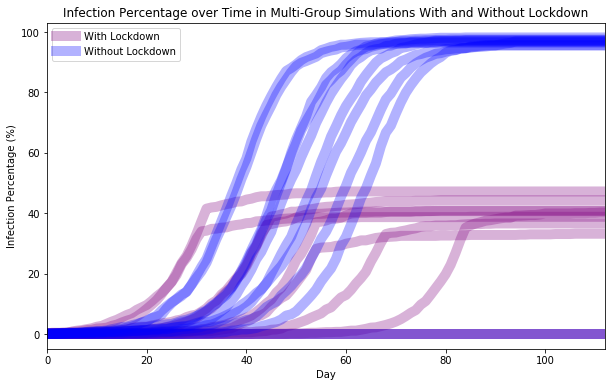

In [9]:
plt.figure(figsize=(10,6))
label='With Lockdown'
for df in lockdown_sim_dfs:
    add_df_plot(df, label=label, color='purple', alpha=0.3, linewidth=10)
    label=''

label='Without Lockdown'
for df in sim_dfs:
    add_df_plot(df, label=label, color='blue', alpha=0.3, linewidth=10)
    label=''

plt.xlabel("Day")
plt.ylabel("Infection Percentage (%)")
plt.legend()
plt.title("Infection Percentage over Time in Multi-Group Simulations With and Without Lockdown")
plt.show()